In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
path=('/home/raul/Documentos/zrive-ds/Datos/feature_frame.csv')

In [4]:
df_feature=pd.read_csv(path)

In [5]:
!poetry add xgboost

Using version ^2.0.3 for xgboost

Updating dependencies
Resolving dependencies... (0.1s)

Package operations: 1 install, 0 updates, 0 removals

  - Installing sklearn (0.0.post7): Pending...
  - Installing sklearn (0.0.post7): Preparing...
  - Installing sklearn (0.0.post7): Failed

  ChefBuildError

  Backend subprocess exited when trying to invoke get_requires_for_build_wheel
  
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands. 
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the envir

Filtramos las cestas con al menos 5 productos

In [5]:
# Filtrar solo las filas donde outcome es 1
df_outcome_1 = df_feature[df_feature['outcome'] == 1]

# Contar el número de productos comprados para cada id de compra
basket_counts = df_outcome_1.groupby('order_id').size()

# Filtrar los ids de compra que tienen al menos 5 productos
basket_ids_at_least_5 = basket_counts[basket_counts >= 5].index

# Filtrar el DataFrame original para obtener las cestas con al menos 5 productos
df_baskets_at_least_5 = df_feature[df_feature['order_id'].isin(basket_ids_at_least_5)]

Divido las variables

In [6]:
info_cols= ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
label_col='outcome'
features_cols=[col for col in df_feature.columns if col not in info_cols + [label_col]]

categoriacal_cols=['product_type', 'vendor']
binary_cols=['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols= [col for col in features_cols if col not in categoriacal_cols + binary_cols]

Funcion para dividir los datos

In [7]:
from sklearn.model_selection import train_test_split

def split_data(df, order_id_col='order_id', outcome='outcome'):
    
    order_ids = df[order_id_col].unique()
    
    order_train, order_temp = train_test_split(order_ids, test_size=0.4, random_state=42)
    order_val, order_test = train_test_split(order_temp, test_size=0.5, random_state=42)
    
    train_set = df[df[order_id_col].isin(order_train)]
    val_set = df[df[order_id_col].isin(order_val)]
    test_set = df[df[order_id_col].isin(order_test)]
    
    X_train = train_set.drop(columns=[outcome])
    y_train = train_set[[outcome]]
    
    X_val = val_set.drop(columns=[outcome])
    y_val = val_set[[outcome]]
    
    X_test = test_set.drop(columns=[outcome])
    y_test = test_set[[outcome]]
    
    return X_train, X_val, X_test, y_train, y_val, y_test



Me quedo solo con las variables numericas

Funcion para escalar los datos con la media y varianza del entrenamiento

In [8]:
from sklearn.preprocessing import StandardScaler

def scale_data(X_train, X_val, X_test):

    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_val_scaled, X_test_scaled



Funcion Regresion Logistica

In [9]:
from sklearn.linear_model import LogisticRegression
def entrenar_regresion_logistica(X_train_scaled, y_train):

    # Inicializar el clasificador de regresión logística
    logistic_regression = LogisticRegression()

    # Entrenar el modelo de regresión logística
    logistic_regression.fit(X_train_scaled, y_train)

    return logistic_regression


Funcion que dibuja las curvas roc y Recall

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

def plot_roc_recall_curves(probs_train, y_train, probs_val, y_val):
    # Calcular la curva ROC para entrenamiento
    fpr_train, tpr_train, _ = roc_curve(y_train, probs_train)
    roc_auc_train = roc_auc_score(y_train, probs_train)

    # Trazar la curva ROC para entrenamiento
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_train)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Training')
    plt.legend(loc="lower right")

    # Calcular la curva de precisión y recall para entrenamiento
    precision_train, recall_train, _ = precision_recall_curve(y_train, probs_train)
    pr_auc_train = auc(recall_train, precision_train)

    # Trazar la curva de precisión y recall para entrenamiento
    plt.subplot(1, 2, 2)
    plt.plot(recall_train, precision_train, color='green', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc_train)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Training')
    plt.legend(loc="lower left")

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

    # Calcular la curva ROC para validación
    fpr_val, tpr_val, _ = roc_curve(y_val, probs_val)
    roc_auc_val = roc_auc_score(y_val, probs_val)

    # Trazar la curva ROC para validación
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr_val, tpr_val, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_val)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Validation')
    plt.legend(loc="lower right")

    # Calcular la curva de precisión y recall para validación
    precision_val, recall_val, _ = precision_recall_curve(y_val, probs_val)
    pr_auc_val = auc(recall_val, precision_val)

    # Trazar la curva de precisión y recall para validación
    plt.subplot(1, 2, 2)
    plt.plot(recall_val, precision_val, color='green', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc_val)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Validation')
    plt.legend(loc="lower left")

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()






In [11]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df_baskets_at_least_5, 'order_id', 'outcome')
X_train=X_train[numerical_cols + binary_cols]
X_val=X_val[numerical_cols + binary_cols]
X_test=X_test[numerical_cols + binary_cols]
X_train_scaled, X_val_scaled, X_test_scaled = scale_data(X_train, X_val, X_test)

/home/raul/Documentos/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


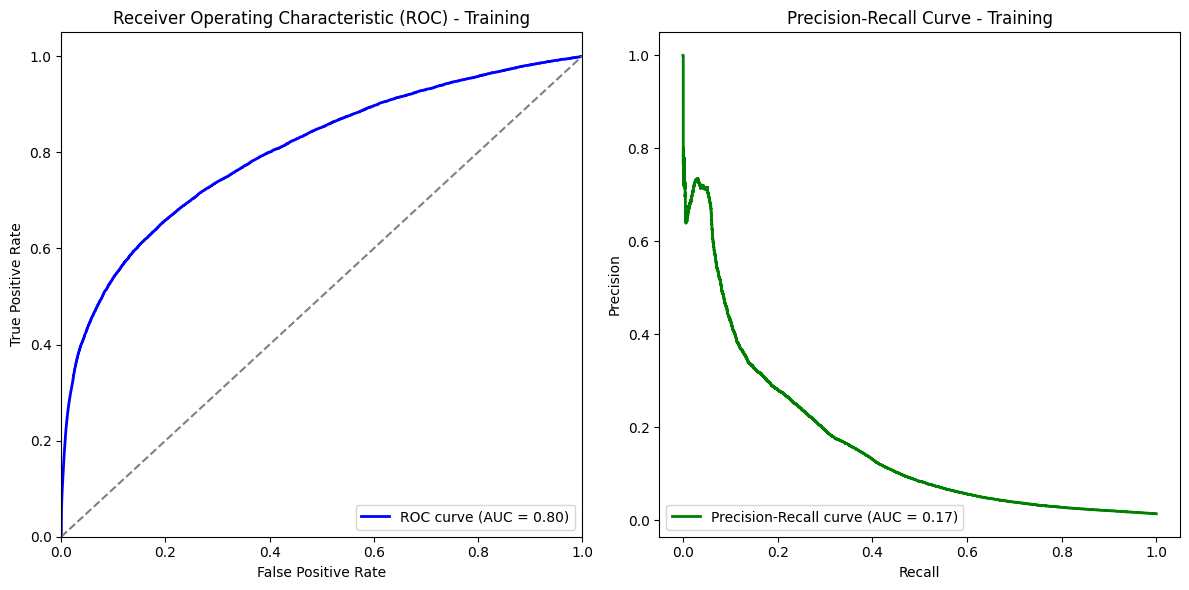

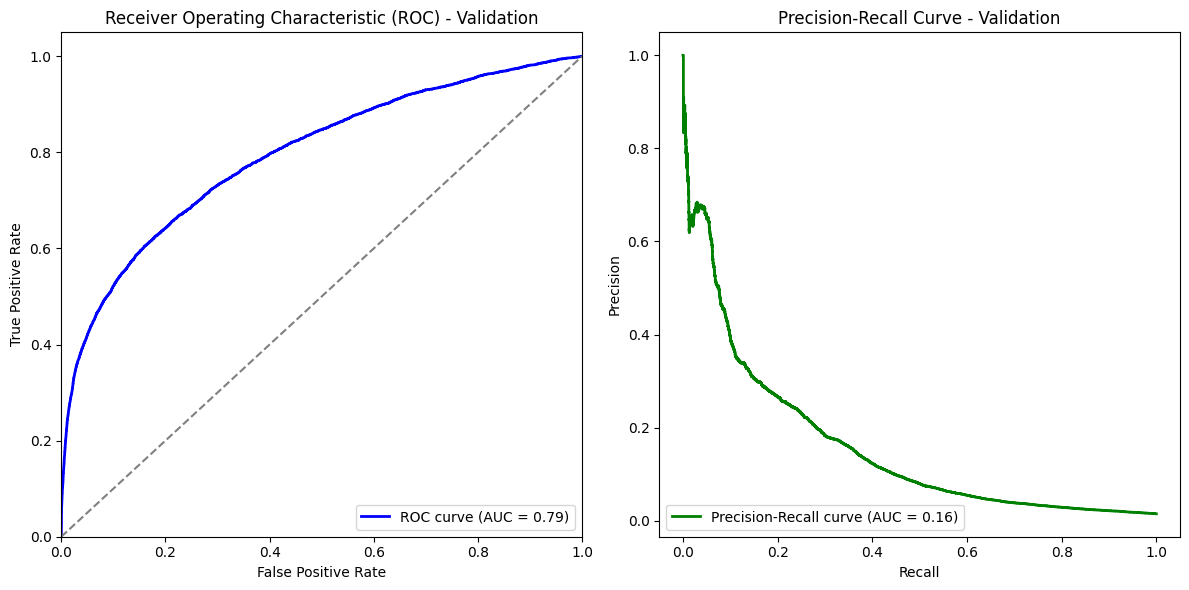

In [13]:
Logistic_regresion_model=entrenar_regresion_logistica(X_train_scaled, y_train)
probs_train = Logistic_regresion_model.predict_proba(X_train_scaled)[:, 1]
probs_val = Logistic_regresion_model.predict_proba(X_val_scaled)[:, 1]
plot_roc_recall_curves(probs_train, y_train, probs_val, y_val)

Ya que tiene un comportamiento muy parecido en train y en validacion, podemos pensar que no necesita regulacion este modelo ya que no esta overfitteando
Este modelo nos sirve como baseline para otros modelos mas complejos

Hacemos primero una seleccion de variables con lasso

In [14]:
from sklearn.feature_selection import SelectFromModel

log_reg = LogisticRegression(penalty='l1', C=0.0001, solver='saga')
log_reg.fit(X_train_scaled, y_train)

coeficientes = log_reg.coef_[0]
nombres_variables = list(X_train.columns)

coeficientes_abs = np.abs(coeficientes)
indices_ordenados = np.argsort(coeficientes_abs)[::-1]
for i in indices_ordenados:
    print(f'{nombres_variables[i]}: {coeficientes[i]}')


/home/raul/Documentos/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ordered_before: 0.3392957810734086
global_popularity: 0.1592964844755292
abandoned_before: 0.10247832052879038
set_as_regular: 0.01798529024465985
active_snoozed: 0.0
avg_days_to_buy_product_type: 0.0
std_days_to_buy_product_type: 0.0
std_days_to_buy_variant_id: 0.0
avg_days_to_buy_variant_id: 0.0
days_since_purchase_variant_id: 0.0
days_since_purchase_product_type: 0.0
people_ex_baby: 0.0
count_pets: 0.0
count_children: 0.0
count_babies: 0.0
count_adults: 0.0
discount_pct: 0.0
normalised_price: 0.0
user_order_seq: 0.0


In [12]:
vars_selected=['ordered_before', 'global_popularity', 'abandoned_before', 'set_as_regular']

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

def plot_metrics(
        model_name, y_pred, y_test, target_precision=0.05, figure=None
):
    precision_, recall_, _ =precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)
    fpr, tpr, _=roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax =plt.subplots(1,2,figsize=(14,7))
    else:
        fig, ax =figure

    ax[0].plot(recall_, precision_, label=f"{model_name}; AUC: {pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title(f"Precision-recall Curve")
    ax[0].legend()


    ax[1].plot(fpr, tpr, label=f"AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title(f"ROC Curve")
    ax[1].legend()


Random Forest con distintos parametros

/home/raul/Documentos/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/raul/Documentos/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/raul/Documentos/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/raul/Documentos/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector 

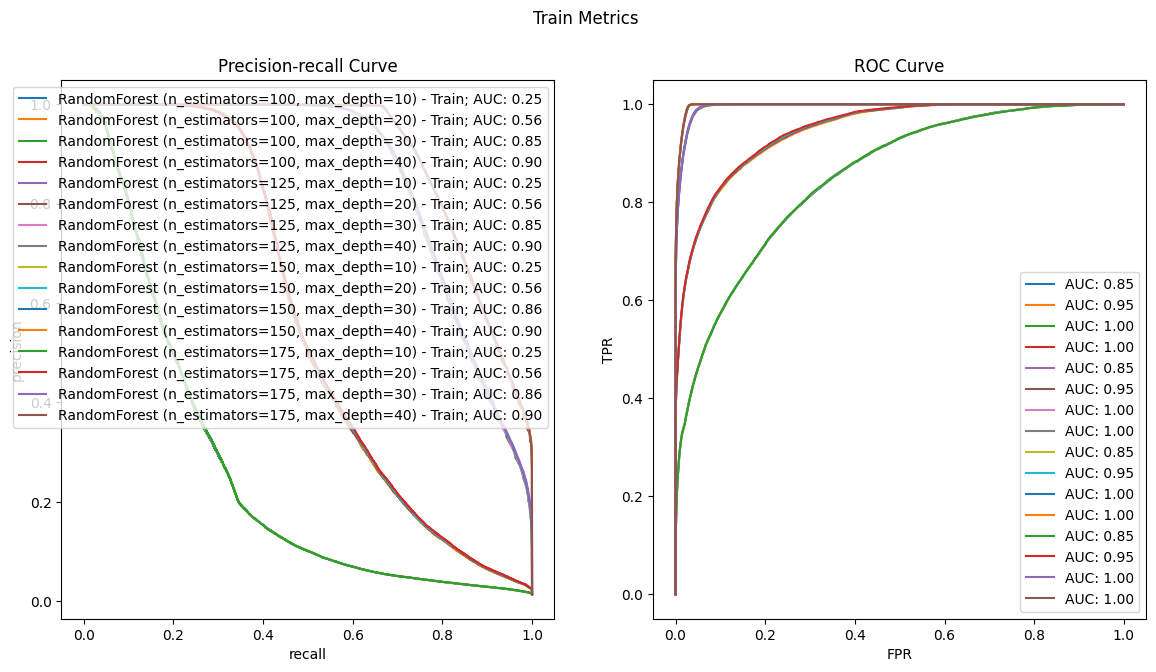

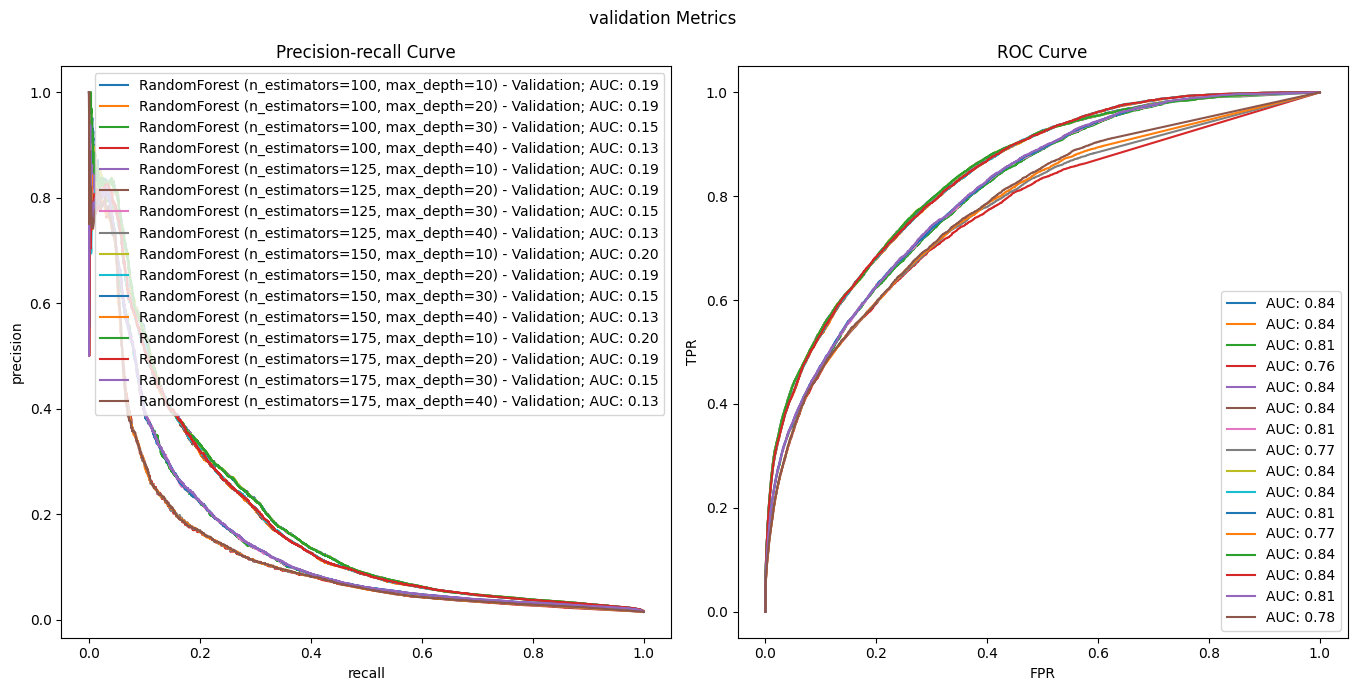

In [104]:
from itertools import product
parameters={'n_estimators': [100,125,150,175], 'max_depth': [10,20,30,40]}
param_combinations = list(product(parameters['n_estimators'], parameters['max_depth']))
# Crear figuras para los gráficos
fig_train, ax_train = plt.subplots(1, 2, figsize=(14, 7))
fig_train.suptitle("Train Metrics")
fig_val, ax_val = plt.subplots(1, 2, figsize=(14, 7))
fig_val.suptitle("validation Metrics")

# Iterar sobre todas las combinaciones de hiperparámetros
for (n_estimators, max_depth) in (param_combinations):
    # Crear y entrenar el modelo RandomForest con la combinación actual de hiperparámetros
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    rf.fit(X_train_scaled, y_train)
    
    # Calcular las predicciones para X_train y X_val
    y_pred_train = rf.predict_proba(X_train_scaled)[:, 1]
    y_pred_val = rf.predict_proba(X_val_scaled)[:, 1]
    
    # Trazar las métricas para X_train
    plot_metrics(f"RandomForest (n_estimators={n_estimators}, max_depth={max_depth}) - Train", 
                 y_pred_train, y_train, figure=(fig_train, ax_train))
    
    # Trazar las métricas para X_val
    plot_metrics(f"RandomForest (n_estimators={n_estimators}, max_depth={max_depth}) - Validation", 
                 y_pred_val, y_val, figure=(fig_val, ax_val))

# Ajustar espaciado entre subgráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

Solo con 4 variables

In [17]:
X_train=X_train[vars_selected]
X_val=X_val[vars_selected]
X_test=X_test[vars_selected]
X_train_scaled, X_val_scaled, X_test_scaled = scale_data(X_train, X_val, X_test)

/home/raul/Documentos/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/raul/Documentos/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/raul/Documentos/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/raul/Documentos/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector 

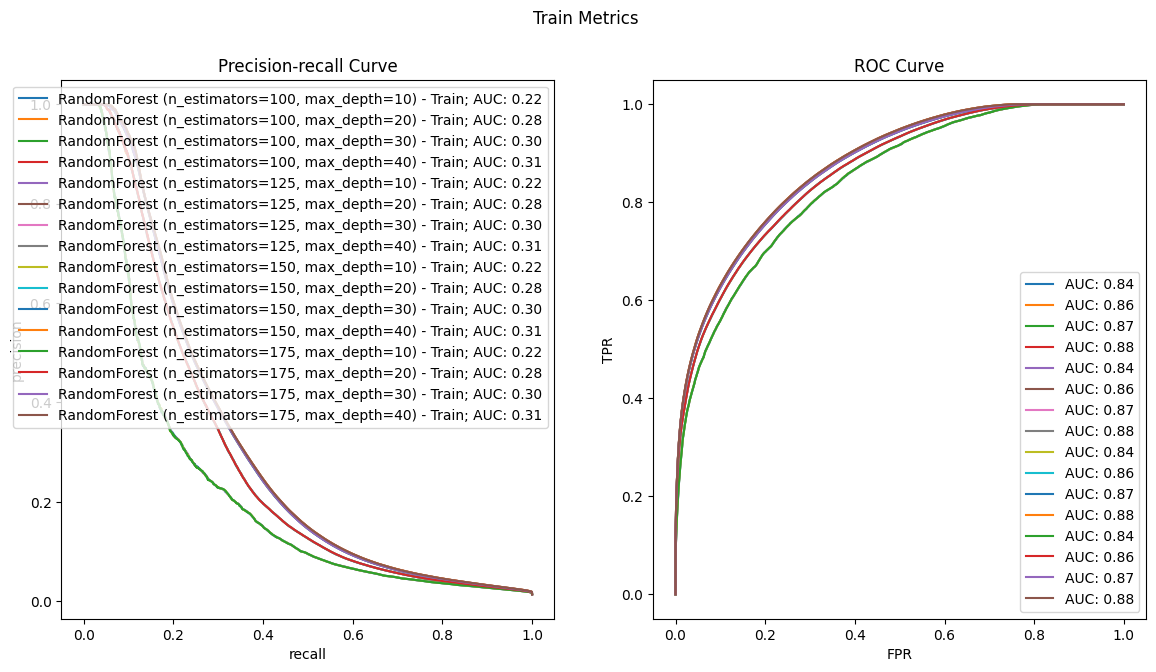

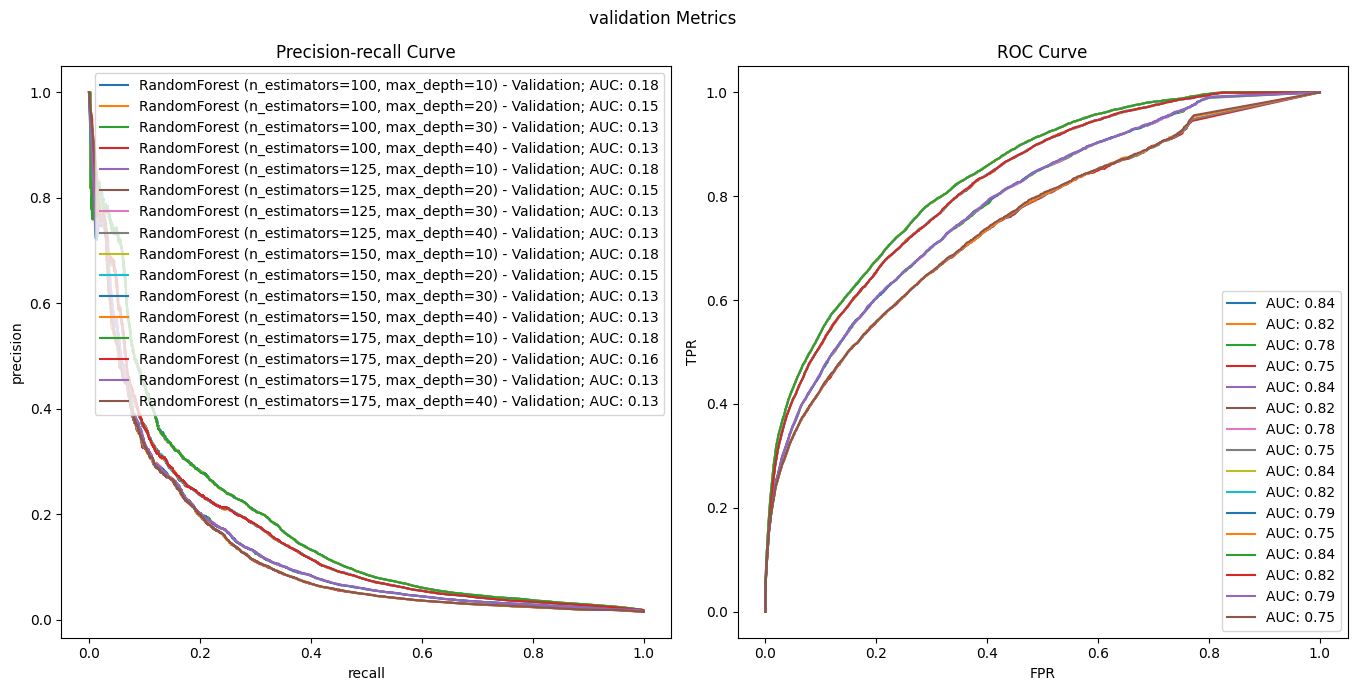

In [21]:
from itertools import product
from sklearn.ensemble import RandomForestClassifier
parameters={'n_estimators': [100,125,150,175], 'max_depth': [10,20,30,40]}
param_combinations = list(product(parameters['n_estimators'], parameters['max_depth']))
# Crear figuras para los gráficos
fig_train, ax_train = plt.subplots(1, 2, figsize=(14, 7))
fig_train.suptitle("Train Metrics")
fig_val, ax_val = plt.subplots(1, 2, figsize=(14, 7))
fig_val.suptitle("validation Metrics")

# Iterar sobre todas las combinaciones de hiperparámetros
for (n_estimators, max_depth) in (param_combinations):
    # Crear y entrenar el modelo RandomForest con la combinación actual de hiperparámetros
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    rf.fit(X_train_scaled, y_train)
    
    # Calcular las predicciones para X_train y X_val
    y_pred_train = rf.predict_proba(X_train_scaled)[:, 1]
    y_pred_val = rf.predict_proba(X_val_scaled)[:, 1]
    
    # Trazar las métricas para X_train
    plot_metrics(f"RandomForest (n_estimators={n_estimators}, max_depth={max_depth}) - Train", 
                 y_pred_train, y_train, figure=(fig_train, ax_train))
    
    # Trazar las métricas para X_val
    plot_metrics(f"RandomForest (n_estimators={n_estimators}, max_depth={max_depth}) - Validation", 
                 y_pred_val, y_val, figure=(fig_val, ax_val))

# Ajustar espaciado entre subgráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

Xgboost

/home/raul/Documentos/zrive-ds/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


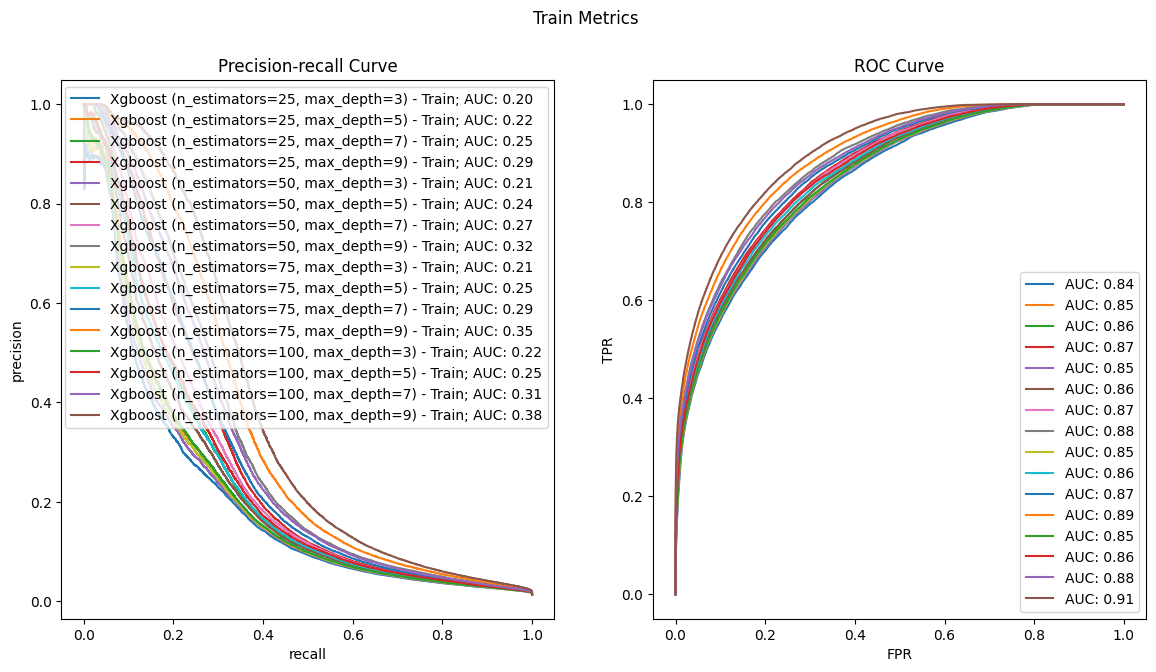

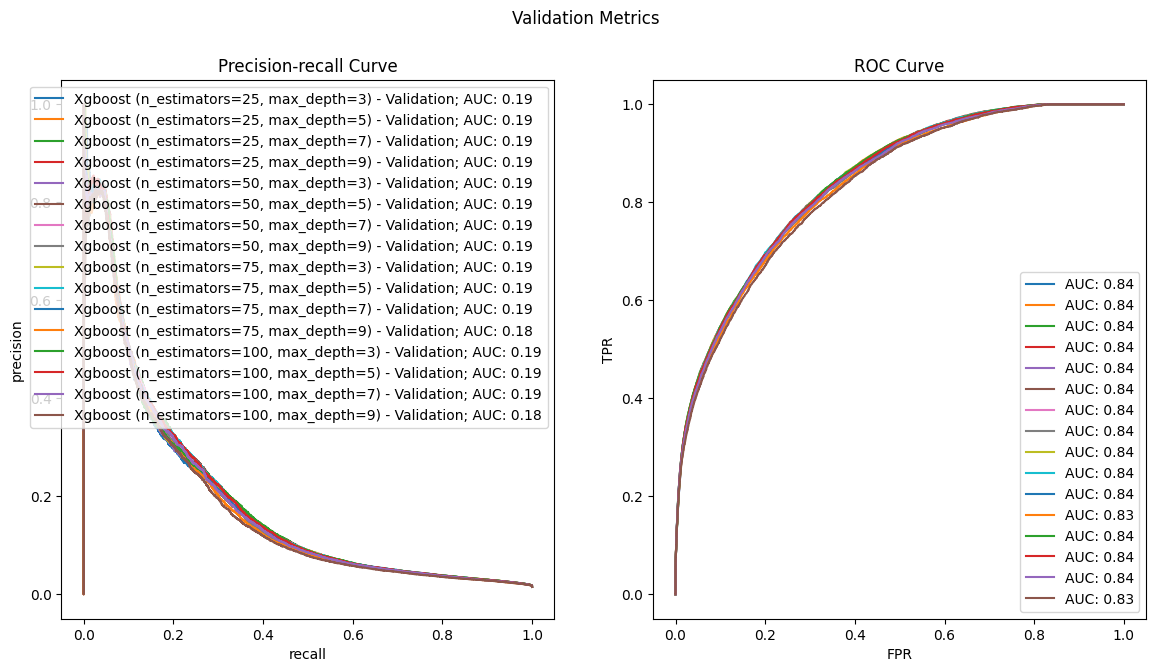

In [23]:
import xgboost as xgb
from itertools import product

parameters = {'n_estimators': [25, 50, 75, 100], 'max_depth': [3, 5, 7, 9]}

# Crear una lista de todas las combinaciones de hiperparámetros
param_combinations = list(product(parameters['n_estimators'], parameters['max_depth']))

# Crear figuras para los gráficos
fig_train, ax_train = plt.subplots(1, 2, figsize=(14, 7))
fig_train.suptitle("Train Metrics")
fig_val, ax_val = plt.subplots(1, 2, figsize=(14, 7))
fig_val.suptitle("Validation Metrics")

# Iterar sobre todas las combinaciones de hiperparámetros
for  (n_estimators, max_depth) in (param_combinations):
    # Crear y entrenar el modelo RandomForest con la combinación actual de hiperparámetros
    xgb_model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    xgb_model.fit(X_train_scaled, y_train)

    
    # Calcular las predicciones para X_train y X_val
    y_pred_train = xgb_model.predict_proba(X_train_scaled)[:, 1]
    y_pred_val = xgb_model.predict_proba(X_val_scaled)[:, 1]
    
    # Trazar las métricas para X_train
    plot_metrics(f"Xgboost (n_estimators={n_estimators}, max_depth={max_depth}) - Train", 
                 y_pred_train, y_train, figure=(fig_train, ax_train))
    
    # Trazar las métricas para X_val
    plot_metrics(f"Xgboost (n_estimators={n_estimators}, max_depth={max_depth}) - Validation", 
                 y_pred_val, y_val, figure=(fig_val, ax_val))


# Mostrar los gráficos
plt.show()

Codifico las variables con hash en 10 varibles, 10 es un parametro a optimizar

In [38]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(max_categories=10, sparse_output=False)

# Ajustar y transformar los datos
encoded_data = encoder.fit_transform(df_baskets_at_least_5[categoriacal_cols])

# Obtener los nombres de las nuevas columnas
column_names = encoder.get_feature_names_out(input_features=df_baskets_at_least_5[categoriacal_cols].columns)

df_encoded = pd.DataFrame(encoded_data, columns=column_names)

df_baskets_at_least_5_enconded=pd.concat([df_baskets_at_least_5[ numerical_cols + binary_cols + ['order_id', 'outcome']],df_encoded] , axis=1)


In [42]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df_baskets_at_least_5_enconded, 'order_id', 'outcome')

X_train_scaled, X_val_scaled, X_test_scaled = scale_data(X_train, X_val, X_test)

In [43]:

rf_classifier=train_random_forest(X_train_scaled, y_train)
rf_classifier_probs_train=rf_classifier.predict_proba(X_train_scaled)[:, 1]
rf_classifier_probs_val=rf_classifier.predict_proba(X_val_scaled)[:, 1]

/home/raul/Documentos/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
compare_roc_recall_curves(baseline_probs_train, baseline_probs_val, rf_classifier_probs_train, rf_classifier_probs_val, y_train, y_val, baseline_label='Regresion Logistica', new_model_label='Random Forest One Hot')

Recodificar variables con frecuencia

In [6]:
# Paso 1: Calcular la frecuencia de cada categoría
frecuencia_categorias = df_baskets_at_least_5['product_type'].value_counts()

# Paso 2: Calcular la frecuencia relativa
frecuencia_relativa = frecuencia_categorias / len(df_baskets_at_least_5)

frecuencia_categorias = df_baskets_at_least_5['vendor'].value_counts()

frecuencia_relativa1 = frecuencia_categorias / len(df_baskets_at_least_5)

df_baskets_at_least_5_rela=df_baskets_at_least_5.copy()
# Paso 3: Asignar la frecuencia relativa a cada categoría en una nueva columna
df_baskets_at_least_5_rela['product_type_relativa'] = df_baskets_at_least_5_rela['product_type'].map(frecuencia_relativa)

df_baskets_at_least_5_rela['vendor_relativa'] = df_baskets_at_least_5_rela['vendor'].map(frecuencia_relativa1)



In [7]:
df_baskets_at_least_5_rela1= df_baskets_at_least_5_rela[ numerical_cols + binary_cols + ['product_type_relativa'] + ['vendor_relativa']]
df_baskets_at_least_5_rela1.head()

,user_order_seq,normalised_price,discount_pct,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,...,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,ordered_before,abandoned_before,active_snoozed,set_as_regular,product_type_relativa,vendor_relativa
0,3,0.081052,0.053512,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,...,31.134053,30.0,30.0,24.27618,0.0,0.0,0.0,0.0,0.044619,0.014435
1,2,0.081052,0.053512,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,...,31.134053,30.0,30.0,24.27618,0.0,0.0,0.0,0.0,0.044619,0.014435
2,4,0.081052,0.053512,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,...,31.134053,30.0,30.0,24.27618,0.0,0.0,0.0,0.0,0.044619,0.014435
3,2,0.081052,0.053512,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,...,31.134053,30.0,30.0,24.27618,0.0,0.0,0.0,0.0,0.044619,0.014435
5,3,0.081052,0.053512,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,...,31.134053,30.0,30.0,24.27618,0.0,0.0,0.0,0.0,0.044619,0.014435


Recodificar variables con Target Encoding

In [8]:

import category_encoders as ce

encoder = ce.TargetEncoder(cols=['product_type', 'vendor'])

# Ajustar el codificador a tus datos
encoder.fit(df_baskets_at_least_5[['product_type', 'vendor']], df_baskets_at_least_5['outcome'])

# Aplicar el codificador a tu DataFrame
encoded_df = encoder.transform(df_baskets_at_least_5[['product_type', 'vendor']])

# Ahora 'encoded_df' contiene la variable categórica codificada
print(encoded_df.head())


ModuleNotFoundError: No module named 'category_encoders'

In [15]:
df_baskets_at_least_5_enconded=pd.concat([df_baskets_at_least_5_rela[ numerical_cols + binary_cols],encoded_df] , axis=1)
df_baskets_at_least_5_enconded.head()

,user_order_seq,normalised_price,discount_pct,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,...,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,ordered_before,abandoned_before,active_snoozed,set_as_regular,product_type,vendor
0,3,0.081052,0.053512,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,...,31.134053,30.0,30.0,24.27618,0.0,0.0,0.0,0.0,0.015587,0.014022
1,2,0.081052,0.053512,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,...,31.134053,30.0,30.0,24.27618,0.0,0.0,0.0,0.0,0.015587,0.014022
2,4,0.081052,0.053512,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,...,31.134053,30.0,30.0,24.27618,0.0,0.0,0.0,0.0,0.015587,0.014022
3,2,0.081052,0.053512,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,...,31.134053,30.0,30.0,24.27618,0.0,0.0,0.0,0.0,0.015587,0.014022
5,3,0.081052,0.053512,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,...,31.134053,30.0,30.0,24.27618,0.0,0.0,0.0,0.0,0.015587,0.014022
